In [90]:
from pathlib import Path

import torch
import torchinfo
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from typing import Generator
import matplotlib.pyplot as plt

from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchlake.image_generation.models.gan import (GANDiscriminator,
                                                   GANGenerator)
from torchlake.common.controller.recorder import TrainRecorder

# Setting

In [91]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [92]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [93]:
DEVICE = torch.device("cuda:0")

# Data

In [94]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [95]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [96]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

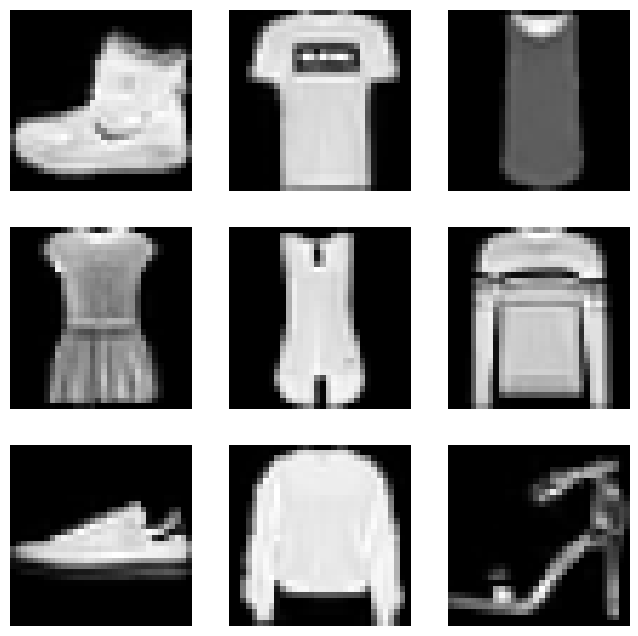

In [97]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [98]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [99]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [100]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
│    └─Unflatten: 2-9                    --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [101]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       524,800
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       131,328
│    └─LeakyReLU: 2-5                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [102]:
def noise_generator(batch_size: int) -> Generator[torch.Tensor, None, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [103]:
EPOCH = 30

In [104]:
trainer = GANTrainer(EPOCH, DEVICE)

In [105]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [106]:
LR = 1e-4
BETA = (0.5, 0.999)

In [107]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [108]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    criterion,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:25<00:00, 18.49it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 3.4380e-03 (0.00%)
generator: 8.0799e-03 (0.00%)


100%|██████████| 468/468 [00:20<00:00, 23.02it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 5.7597e-03 (68.00%)
generator: 2.5961e-02 (221.00%)


100%|██████████| 468/468 [00:22<00:00, 20.85it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 8.3314e-03 (45.00%)
generator: 4.3923e-02 (69.00%)


100%|██████████| 468/468 [00:22<00:00, 20.42it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 1.1458e-02 (38.00%)
generator: 5.9629e-02 (36.00%)


100%|██████████| 468/468 [00:23<00:00, 19.91it/s]


------------------------------------
Epoch 5
------------------------------------
discriminator: 1.4683e-02 (28.00%)
generator: 7.5473e-02 (27.00%)


100%|██████████| 468/468 [00:22<00:00, 21.14it/s]


------------------------------------
Epoch 6
------------------------------------
discriminator: 1.7867e-02 (22.00%)
generator: 9.0486e-02 (20.00%)


100%|██████████| 468/468 [00:22<00:00, 20.86it/s]


------------------------------------
Epoch 7
------------------------------------
discriminator: 2.0943e-02 (17.00%)
generator: 1.0668e-01 (18.00%)


100%|██████████| 468/468 [00:21<00:00, 22.02it/s]


------------------------------------
Epoch 8
------------------------------------
discriminator: 2.4315e-02 (16.00%)
generator: 1.2127e-01 (14.00%)


100%|██████████| 468/468 [00:21<00:00, 21.93it/s]


------------------------------------
Epoch 9
------------------------------------
discriminator: 2.7823e-02 (14.00%)
generator: 1.3487e-01 (11.00%)


100%|██████████| 468/468 [00:21<00:00, 21.53it/s]


------------------------------------
Epoch 10
------------------------------------
discriminator: 3.1408e-02 (13.00%)
generator: 1.4756e-01 (9.00%)


100%|██████████| 468/468 [00:21<00:00, 21.43it/s]


------------------------------------
Epoch 11
------------------------------------
discriminator: 3.5171e-02 (12.00%)
generator: 1.5991e-01 (8.00%)


100%|██████████| 468/468 [00:21<00:00, 21.45it/s]


------------------------------------
Epoch 12
------------------------------------
discriminator: 3.9240e-02 (12.00%)
generator: 1.7104e-01 (7.00%)


100%|██████████| 468/468 [00:21<00:00, 21.58it/s]


------------------------------------
Epoch 13
------------------------------------
discriminator: 4.3435e-02 (11.00%)
generator: 1.8140e-01 (6.00%)


100%|██████████| 468/468 [00:21<00:00, 21.56it/s]


------------------------------------
Epoch 14
------------------------------------
discriminator: 4.7627e-02 (10.00%)
generator: 1.9178e-01 (6.00%)


100%|██████████| 468/468 [00:21<00:00, 21.56it/s]


------------------------------------
Epoch 15
------------------------------------
discriminator: 5.2023e-02 (9.00%)
generator: 2.0147e-01 (5.00%)


100%|██████████| 468/468 [00:21<00:00, 21.42it/s]


------------------------------------
Epoch 16
------------------------------------
discriminator: 5.6507e-02 (9.00%)
generator: 2.1088e-01 (5.00%)


100%|██████████| 468/468 [00:21<00:00, 21.53it/s]


------------------------------------
Epoch 17
------------------------------------
discriminator: 6.1127e-02 (8.00%)
generator: 2.1977e-01 (4.00%)


100%|██████████| 468/468 [00:21<00:00, 21.55it/s]


------------------------------------
Epoch 18
------------------------------------
discriminator: 6.5820e-02 (8.00%)
generator: 2.2839e-01 (4.00%)


100%|██████████| 468/468 [00:22<00:00, 21.01it/s]


------------------------------------
Epoch 19
------------------------------------
discriminator: 7.0576e-02 (7.00%)
generator: 2.3661e-01 (4.00%)


100%|██████████| 468/468 [00:22<00:00, 21.23it/s]


------------------------------------
Epoch 20
------------------------------------
discriminator: 7.5335e-02 (7.00%)
generator: 2.4476e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.30it/s]


------------------------------------
Epoch 21
------------------------------------
discriminator: 8.0091e-02 (6.00%)
generator: 2.5287e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.36it/s]


------------------------------------
Epoch 22
------------------------------------
discriminator: 8.4855e-02 (6.00%)
generator: 2.6083e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.48it/s]


------------------------------------
Epoch 23
------------------------------------
discriminator: 8.9650e-02 (6.00%)
generator: 2.6877e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.45it/s]


------------------------------------
Epoch 24
------------------------------------
discriminator: 9.4489e-02 (5.00%)
generator: 2.7653e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.31it/s]


------------------------------------
Epoch 25
------------------------------------
discriminator: 9.9403e-02 (5.00%)
generator: 2.8408e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.55it/s]


------------------------------------
Epoch 26
------------------------------------
discriminator: 1.0433e-01 (5.00%)
generator: 2.9164e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.52it/s]


------------------------------------
Epoch 27
------------------------------------
discriminator: 1.0927e-01 (5.00%)
generator: 2.9911e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.29it/s]


------------------------------------
Epoch 28
------------------------------------
discriminator: 1.1426e-01 (5.00%)
generator: 3.0635e-01 (2.00%)


100%|██████████| 468/468 [00:21<00:00, 21.42it/s]


------------------------------------
Epoch 29
------------------------------------
discriminator: 1.1927e-01 (4.00%)
generator: 3.1352e-01 (2.00%)


100%|██████████| 468/468 [00:21<00:00, 21.43it/s]

------------------------------------
Epoch 30
------------------------------------
discriminator: 1.2428e-01 (4.00%)
generator: 3.2067e-01 (2.00%)


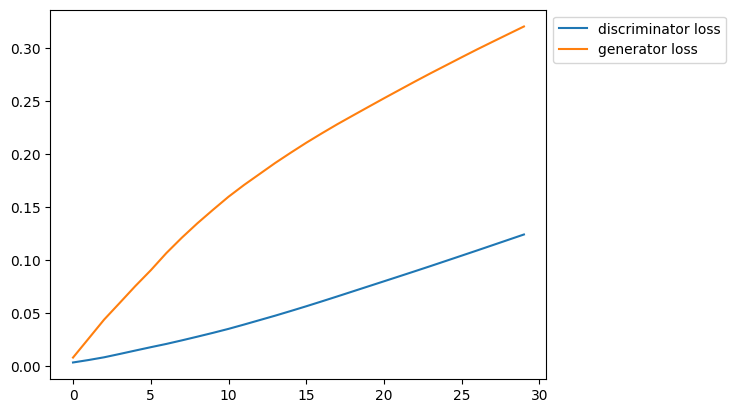

In [109]:
plt.plot(training_losses[0], label="discriminator loss")
plt.plot(training_losses[1], label="generator loss")
plt.legend(bbox_to_anchor=(1, 1))

# evaluation

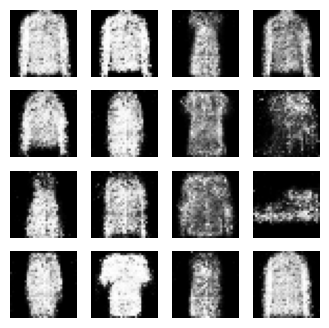

In [145]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [146]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:13<00:00, 33.86it/s]

0.5361833333333333


In [147]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:15<00:00, 31.04it/s]

0.21176666666666666


In [52]:
model_path = artifact_path / 'gan.pth'

In [53]:
torch.save(generator.state_dict(), model_path.as_posix())

In [54]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>